In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

In [3]:
fish_data = pd.read_csv('datasets/fish_data.csv')
fish_data.head()

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31


In [4]:
rows, columns = fish_data.shape

print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 4080
Number of columns: 4


In [5]:
fish_data = fish_data.dropna()
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")


Number of rows: 4080
Number of columns: 4


In [6]:
fish_data = fish_data.drop_duplicates()
rows, columns = fish_data.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")


Number of rows: 3971
Number of columns: 4


In [7]:
features = ['length', 'weight', 'w_l_ratio']
X = fish_data[features].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
results = {
        'kmeans': {
            'silhouette': [],
            'calinski_harabasz': [],
            'davies_bouldin': []
        },
        'gmm': {
            'silhouette': [],
            'calinski_harabasz': [],
            'davies_bouldin': []
        }
    }

In [9]:
def evaluate_clustering(X, labels):
    """
    Calculate multiple clustering evaluation metrics
    
    Parameters:
    X: scaled feature matrix
    labels: cluster labels
    
    Returns:
    dict: Dictionary of evaluation metrics
    """
    metrics = {
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels)
    }
    return metrics

In [10]:
kmeans_scores = []
gmm_scores = []
max_clusters = 10

for n_clusters in range(2, max_clusters + 1):
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    kmeans_metrics = evaluate_clustering(X_scaled, kmeans_labels)
    
    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    gmm_metrics = evaluate_clustering(X_scaled, gmm_labels)
    
    # Store all metrics
    for metric_name in kmeans_metrics:
        results['kmeans'][metric_name].append(kmeans_metrics[metric_name])
        results['gmm'][metric_name].append(gmm_metrics[metric_name])


In [11]:
# Find optimal number of clusters
optimal_k_kmeans = np.argmax(results['kmeans']['silhouette']) + 2
print(f"Optimal number of clusters for KMeans: {optimal_k_kmeans}")
optimal_k_gmm = np.argmax(results['gmm']['silhouette']) + 2
print(f"Optimal number of clusters for GMM: {optimal_k_gmm}")

# Fit final models with optimal clusters
final_kmeans = KMeans(n_clusters=optimal_k_kmeans, random_state=42)
final_gmm = GaussianMixture(n_components=optimal_k_gmm, random_state=42)

kmeans_labels = final_kmeans.fit_predict(X_scaled)
gmm_labels = final_gmm.fit_predict(X_scaled)

Optimal number of clusters for KMeans: 9
Optimal number of clusters for GMM: 9


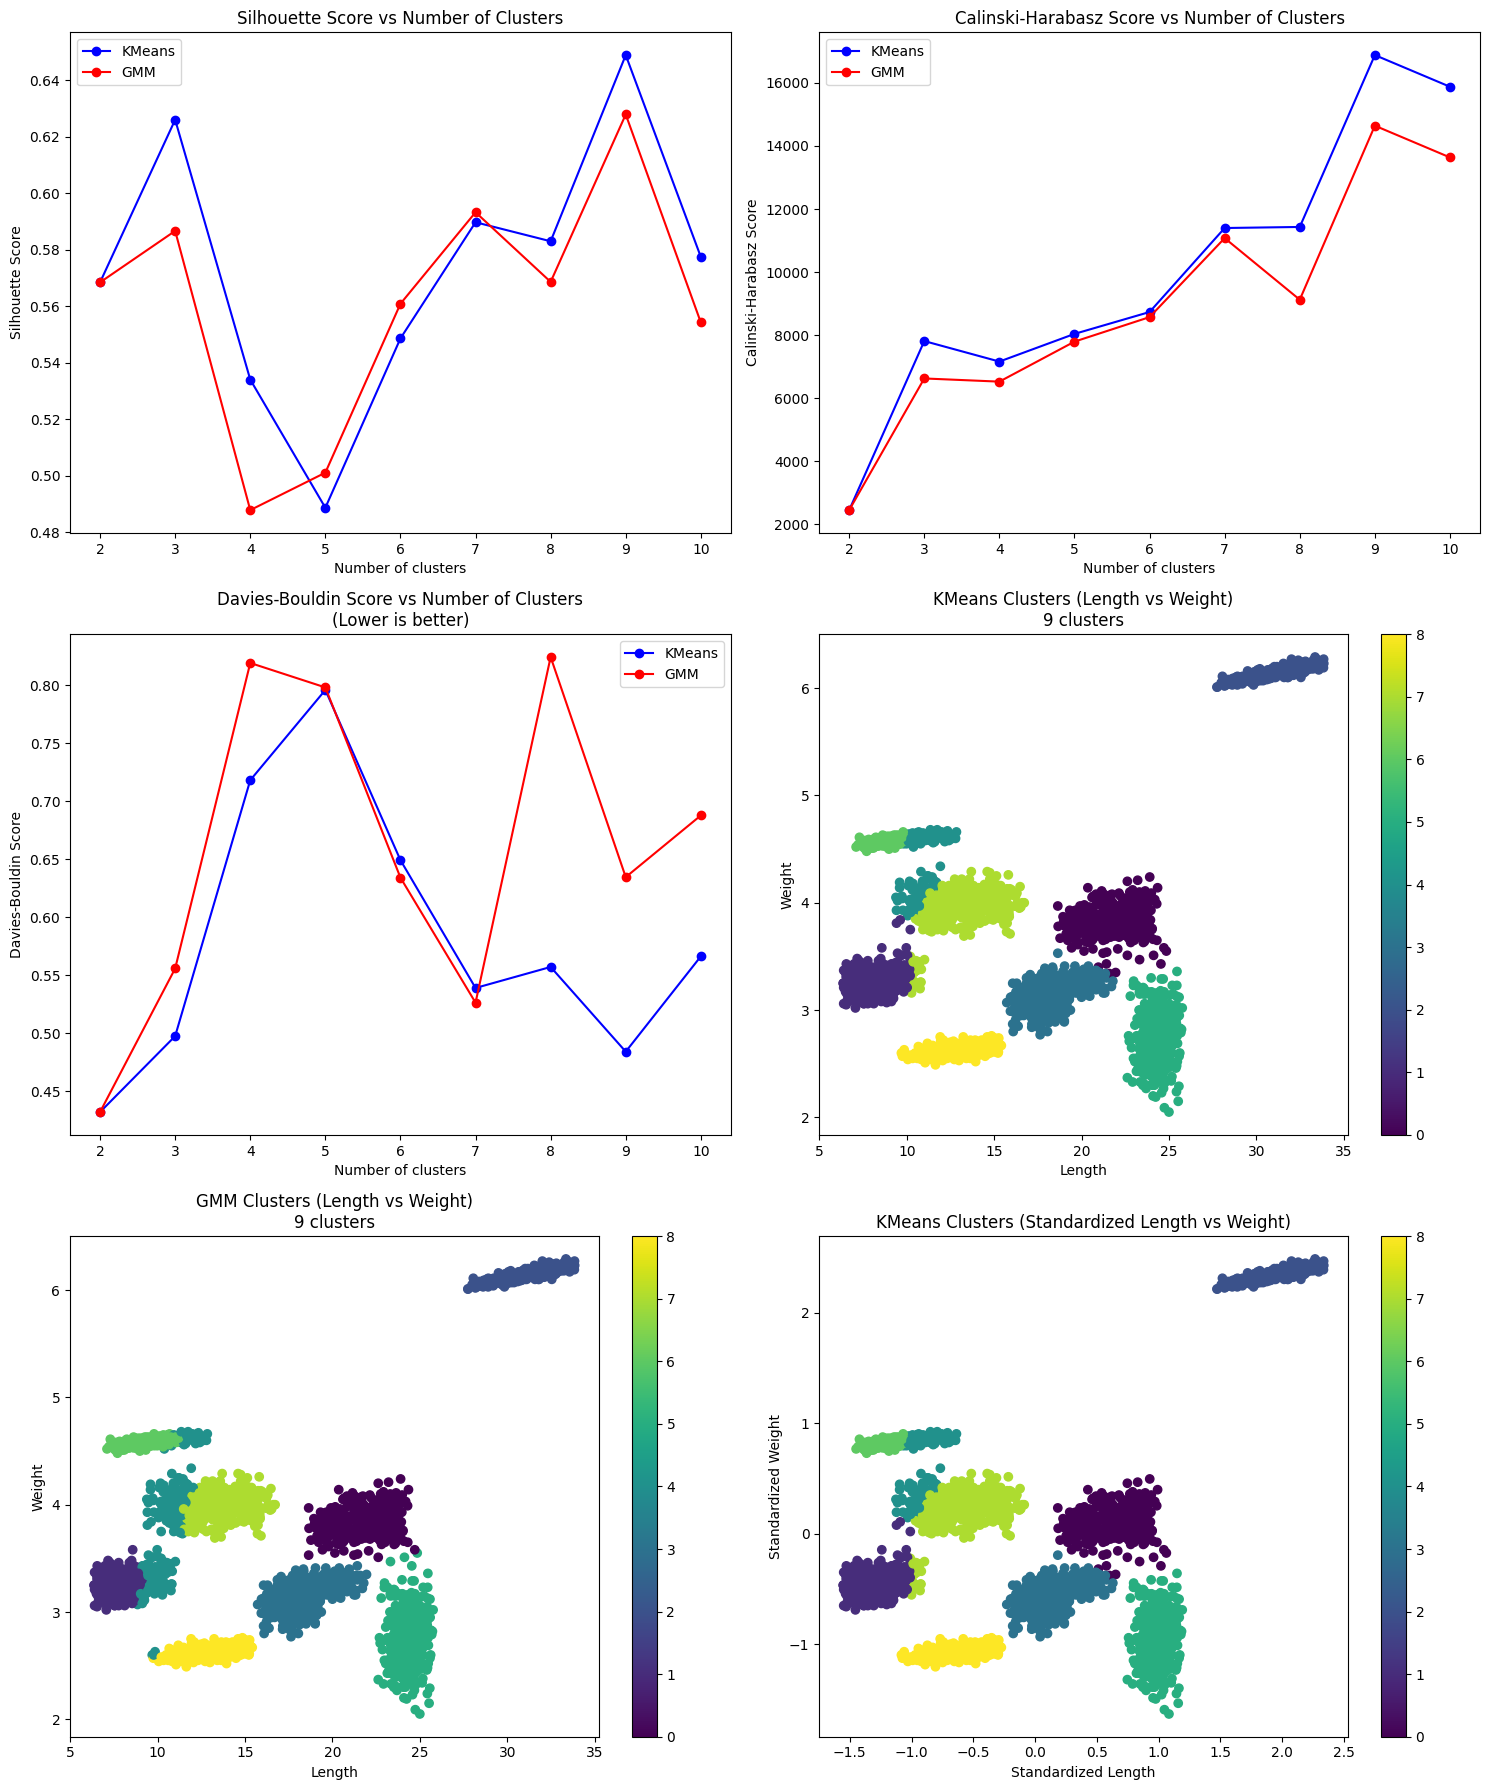

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
# Plot evaluation metrics
cluster_range = range(2, max_clusters + 1)

# Plot silhouette scores
axes[0, 0].plot(cluster_range, results['kmeans']['silhouette'], 'bo-', label='KMeans')
axes[0, 0].plot(cluster_range, results['gmm']['silhouette'], 'ro-', label='GMM')
axes[0, 0].set_xlabel('Number of clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
axes[0, 0].legend()

# Plot Calinski-Harabasz scores
axes[0, 1].plot(cluster_range, results['kmeans']['calinski_harabasz'], 'bo-', label='KMeans')
axes[0, 1].plot(cluster_range, results['gmm']['calinski_harabasz'], 'ro-', label='GMM')
axes[0, 1].set_xlabel('Number of clusters')
axes[0, 1].set_ylabel('Calinski-Harabasz Score')
axes[0, 1].set_title('Calinski-Harabasz Score vs Number of Clusters')
axes[0, 1].legend()

# Plot Davies-Bouldin scores
axes[1, 0].plot(cluster_range, results['kmeans']['davies_bouldin'], 'bo-', label='KMeans')
axes[1, 0].plot(cluster_range, results['gmm']['davies_bouldin'], 'ro-', label='GMM')
axes[1, 0].set_xlabel('Number of clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].set_title('Davies-Bouldin Score vs Number of Clusters\n(Lower is better)')
axes[1, 0].legend()

# Plot original data with KMeans clusters
scatter = axes[1, 1].scatter(fish_data['length'], fish_data['weight'], c=kmeans_labels, cmap='viridis')
axes[1, 1].set_xlabel('Length')
axes[1, 1].set_ylabel('Weight')
axes[1, 1].set_title(f'KMeans Clusters (Length vs Weight)\n{optimal_k_kmeans} clusters')
plt.colorbar(scatter, ax=axes[1, 1])

# Plot original data with GMM clusters
scatter = axes[2, 0].scatter(fish_data['length'], fish_data['weight'], c=gmm_labels, cmap='viridis')
axes[2, 0].set_xlabel('Length')
axes[2, 0].set_ylabel('Weight')
axes[2, 0].set_title(f'GMM Clusters (Length vs Weight)\n{optimal_k_gmm} clusters')
plt.colorbar(scatter, ax=axes[2, 0])

# Plot scaled data with KMeans clusters
scatter = axes[2, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis')
axes[2, 1].set_xlabel('Standardized Length')
axes[2, 1].set_ylabel('Standardized Weight')
axes[2, 1].set_title('KMeans Clusters (Standardized Length vs Weight)')
plt.colorbar(scatter, ax=axes[2, 1])

plt.tight_layout()

# Add cluster labels to original dataframe

